# Time-series Prediction using MLP & LSTM

In [ ]:
# From: https://machinelearningmastery.com/exploratory-configuration-multilayer-perceptron-network-time-series-forecasting/
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import datetime
import numpy as np

## Datetime parser

In [ ]:
def parser(x):
	return datetime.strptime(x, '%Y-%m-%d')

## Load dataset

In [ ]:
dataset = pd.read_csv('/content/sample_data/birth.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

dataset

Date
1959-01-01    35
1959-01-02    32
1959-01-03    30
1959-01-04    31
1959-01-05    44
              ..
1959-12-27    37
1959-12-28    52
1959-12-29    48
1959-12-30    55
1959-12-31    50
Name: Births, Length: 365, dtype: int64

## Plot dataset

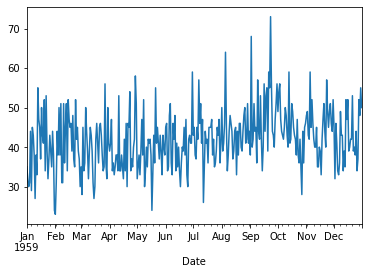

In [ ]:
dataset.plot()
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error
from math import sqrt

## Processing Time-series Data

In [ ]:
def timeseries_to_supervised(data, lag=1):
	df = pd.DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = pd.concat(columns, axis=1)
	return df

def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [ ]:
lag = 1

raw_values = dataset.values
diff_values = difference(raw_values, 1)

diff_values

0      -3
1      -2
2       1
3      13
4     -15
       ..
359     3
360    15
361    -4
362     7
363    -5
Length: 364, dtype: int64

In [ ]:
supervised = timeseries_to_supervised(diff_values, lag)
supervised

,0,0
0,NaN,-3
1,-3.0,-2
2,-2.0,1
3,1.0,13
4,13.0,-15
...,...,...
359,-10.0,3
360,3.0,15
361,15.0,-4
362,-4.0,7


In [ ]:
supervised_values = supervised.values[lag:,:]
supervised_values

array([[ -3.,  -2.],
       [ -2.,   1.],
       [  1.,  13.],
       [ 13., -15.],
       [-15.,  16.],
       [ 16.,  -2.],
       [ -2.,  -5.],
       [ -5., -11.],
       [-11.,  11.],
       [ 11.,  -5.],
       [ -5.,  22.],
       [ 22.,  -8.],
       [ -8.,  -2.],
       [ -2.,  -8.],
       [ -8.,  13.],
       [ 13.,  -7.],
       [ -7.,  -2.],
       [ -2.,  11.],
       [ 11., -18.],
       [-18.,  19.],
       [ 19., -14.],
       [-14.,  -7.],
       [ -7.,   5.],
       [  5.,   6.],
       [  6.,  -4.],
       [ -4.,  -4.],
       [ -4.,   9.],
       [  9.,  -6.],
       [ -6., -14.],
       [-14.,  -1.],
       [ -1.,   8.],
       [  8.,  13.],
       [ 13.,  -6.],
       [ -6.,  12.],
       [ 12., -12.],
       [-12.,  13.],
       [ 13., -20.],
       [-20.,   0.],
       [  0.,  20.],
       [ 20., -15.],
       [-15.,   9.],
       [  9.,   6.],
       [  6., -17.],
       [-17.,  18.],
       [ 18.,  -5.],
       [ -5.,  -2.],
       [ -2.,   1.],
       [  1.,

In [ ]:
split_percentage = 0.75

train_size = int(split_percentage * len(supervised_values))

train, test = supervised_values[0:train_size], supervised_values[train_size:len(supervised_values)]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1)) # Range hasil scaling menjadi angka diantara -1 hingga 1
scaler = scaler.fit(train)

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

In [ ]:
train_scaled

array([[-1.37931034e-01, -1.03448276e-01],
       [-1.03448276e-01, -6.93889390e-17],
       [-6.93889390e-17,  4.13793103e-01],
       [ 4.13793103e-01, -5.51724138e-01],
       [-5.51724138e-01,  5.17241379e-01],
       [ 5.17241379e-01, -1.03448276e-01],
       [-1.03448276e-01, -2.06896552e-01],
       [-2.06896552e-01, -4.13793103e-01],
       [-4.13793103e-01,  3.44827586e-01],
       [ 3.44827586e-01, -2.06896552e-01],
       [-2.06896552e-01,  7.24137931e-01],
       [ 7.24137931e-01, -3.10344828e-01],
       [-3.10344828e-01, -1.03448276e-01],
       [-1.03448276e-01, -3.10344828e-01],
       [-3.10344828e-01,  4.13793103e-01],
       [ 4.13793103e-01, -2.75862069e-01],
       [-2.75862069e-01, -1.03448276e-01],
       [-1.03448276e-01,  3.44827586e-01],
       [ 3.44827586e-01, -6.55172414e-01],
       [-6.55172414e-01,  6.20689655e-01],
       [ 6.20689655e-01, -5.17241379e-01],
       [-5.17241379e-01, -2.75862069e-01],
       [-2.75862069e-01,  1.37931034e-01],
       [ 1.

# Baseline model

In [ ]:
neurons = 1
epoch = 1000
batch_size = 32

feature_train, label_train = train_scaled[:, 0:-1], train_scaled[:, -1]
feature_test, label_test = test_scaled[:, 0:-1], test_scaled[:, -1]

model = Sequential()
model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
9/9 [==============================] - 0s 15ms/step - loss: 0.1119 - val_loss: 0.0702
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1114 - val_loss: 0.0700
Epoch 3/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1112 - val_loss: 0.0698
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1111 - val_loss: 0.0697
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1110 - val_loss: 0.0696
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1110 - val_loss: 0.0696
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1109 - val_loss: 0.0695
Epoch 8/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1109 - val_loss: 0.0695
Epoch 9/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1108 - val_loss: 0.0695
Epoch 10/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1108 - val_loss: 0.0695
Epoch 11/1000
9/9 

In [ ]:
loss = model.evaluate(feature_test, label_test, verbose=2)

print("Test loss:", loss)

3/3 - 0s - loss: 0.0694
Test loss: 0.06939668953418732


In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss (MSE)')
  plt.legend()
  plt.grid(True)

In [ ]:
history_dataframe = pd.DataFrame(history.history)
history_dataframe['epoch'] = history.epoch
history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
652,0.110769,0.069397,652
944,0.110760,0.069397,944
225,0.110779,0.069397,225
130,0.110783,0.069397,130
264,0.110758,0.069397,264
...,...,...,...
4,0.111017,0.069637,4
3,0.111118,0.069719,3
2,0.111190,0.069833,2
1,0.111407,0.069961,1


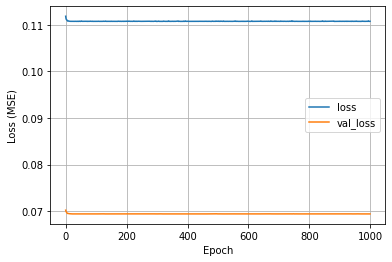

In [ ]:
plot_loss(history) # epoch vs loss graph

# Deeper model

In [ ]:
neurons = 1
epoch = 1000
batch_size = 32

deeper_model = Sequential()
deeper_model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
deeper_model.add(Dense(5, activation='relu'))
deeper_model.add(Dense(1))
deeper_model.compile(loss='mean_squared_error', optimizer='adam')
deeper_model_history = deeper_model.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
9/9 [==============================] - 0s 13ms/step - loss: 0.1131 - val_loss: 0.0707
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1119 - val_loss: 0.0699
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1110 - val_loss: 0.0694
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1104 - val_loss: 0.0691
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1100 - val_loss: 0.0688
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1097 - val_loss: 0.0686
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1094 - val_loss: 0.0684
Epoch 8/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1091 - val_loss: 0.0681
Epoch 9/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1087 - val_loss: 0.0679
Epoch 10/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1083 - val_loss: 0.0676
Epoch 11/1000
9/9 

In [ ]:
deeper_history_dataframe = pd.DataFrame(deeper_model_history.history)
deeper_history_dataframe['epoch'] = deeper_model_history.epoch
deeper_history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
58,0.081933,0.053766,58
59,0.081772,0.053770,59
57,0.081889,0.053778,57
61,0.081517,0.053781,61
60,0.081566,0.053785,60
...,...,...,...
4,0.110007,0.068812,4
3,0.110358,0.069076,3
2,0.111048,0.069387,2
1,0.111913,0.069893,1


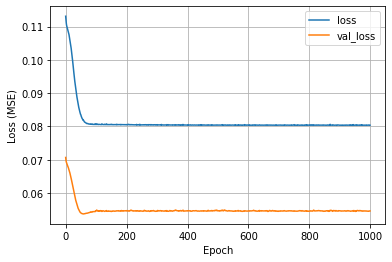

In [ ]:
plot_loss(deeper_model_history) # epoch vs loss graph

# Wider model

In [ ]:
neurons = 50
epoch = 1000
batch_size = 32

wider_model = Sequential()
wider_model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
wider_model.add(Dense(1))
wider_model.compile(loss='mean_squared_error', optimizer='adam')
wider_model_history = wider_model.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
9/9 [==============================] - 0s 13ms/step - loss: 0.1154 - val_loss: 0.0682
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1040 - val_loss: 0.0628
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0968 - val_loss: 0.0599
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0916 - val_loss: 0.0583
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0893 - val_loss: 0.0573
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0876 - val_loss: 0.0568
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0864 - val_loss: 0.0564
Epoch 8/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0856 - val_loss: 0.0561
Epoch 9/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0848 - val_loss: 0.0561
Epoch 10/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0843 - val_loss: 0.0557
Epoch 11/1000
9/9 

In [ ]:
wider_history_dataframe = pd.DataFrame(wider_model_history.history)
wider_history_dataframe['epoch'] = wider_model_history.epoch
wider_history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
185,0.080761,0.054132,185
91,0.080832,0.054135,91
213,0.080363,0.054231,213
114,0.080685,0.054237,114
127,0.080706,0.054239,127
...,...,...,...
4,0.089302,0.057294,4
3,0.091602,0.058325,3
2,0.096753,0.059924,2
1,0.103962,0.062768,1


# LSTM

LSTM (Long Short Term Memory) Network adalah salah satu contoh Recurrent Neural Network (RNN) yang berfungsi baik untuk data sequential yang saling bergantung satu sama lain.

Contoh pengaplikasian:
  - Speech recognition
  - Translation
  - Optical Character Recognition

https://medium.com/mlreview/understanding-lstm-and-its-diagrams-37e2f46f1714

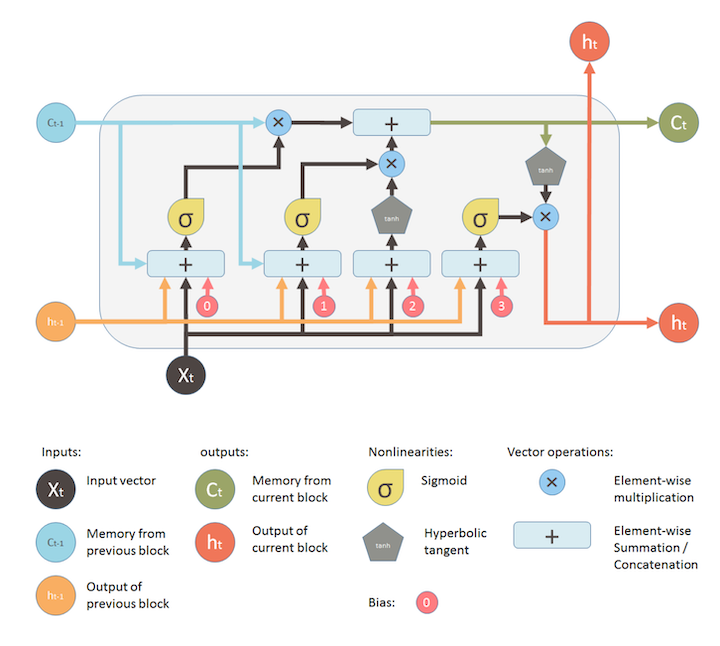

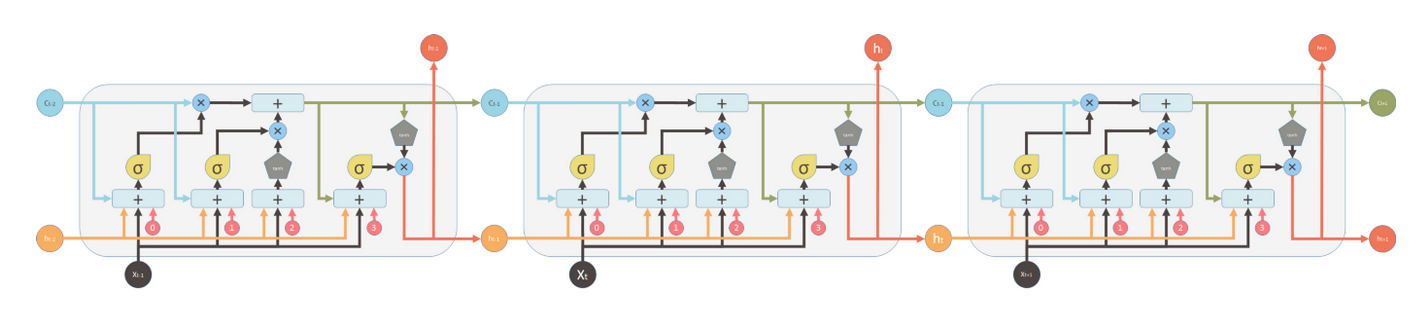

Menghasilkan suatu output berdasarkan data sekarang, data sebelumnya, dan "memory" dari data sebelumnya.

In [ ]:
from tensorflow.keras.layers import LSTM

epoch = 1000
batch_size = 32

# Reshape menjadi (jumlah sample, time steps, jumlah feature)
# Time steps: jumlah lag, gunakan default 1
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
feature_train_reshaped = np.reshape(feature_train, (feature_train.shape[0], 1, feature_train.shape[1]))
feature_test_reshaped = np.reshape(feature_test, (feature_test.shape[0], 1, feature_test.shape[1]))

lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_dim=feature_train.shape[1])) # 50 LSTM Block
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

lstm_model_history = lstm_model.fit(feature_train_reshaped, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test_reshaped, label_test))

Epoch 1/1000
9/9 [==============================] - 0s 27ms/step - loss: 0.1127 - val_loss: 0.0700
Epoch 2/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1102 - val_loss: 0.0686
Epoch 3/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1081 - val_loss: 0.0675
Epoch 4/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1063 - val_loss: 0.0666
Epoch 5/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1047 - val_loss: 0.0656
Epoch 6/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1032 - val_loss: 0.0647
Epoch 7/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1016 - val_loss: 0.0639
Epoch 8/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1001 - val_loss: 0.0631
Epoch 9/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.0988 - val_loss: 0.0623
Epoch 10/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.0972 - val_loss: 0.0615
Epoch 11/1000
9/9 

In [ ]:
lstm_history_dataframe = pd.DataFrame(lstm_model_history.history)
lstm_history_dataframe['epoch'] = lstm_model_history.epoch
lstm_history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
163,0.080397,0.054559,163
357,0.080315,0.054564,357
915,0.080508,0.054566,915
218,0.080288,0.054572,218
68,0.080501,0.054573,68
...,...,...,...
4,0.104731,0.065616,4
3,0.106333,0.066562,3
2,0.108098,0.067526,2
1,0.110170,0.068643,1


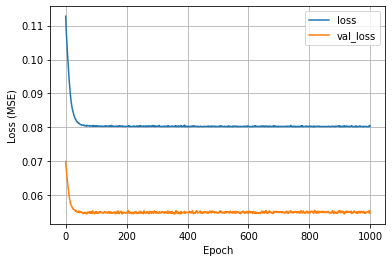

In [ ]:
plot_loss(lstm_model_history)

# Assignment

Lakukan time-series prediction terhadap dataset **Daily Min Temperature** dan **Birth**! Gunakan:
  1. Base model
  2. Deeper model
  3. Wider model
  4. LSTM

Tentukan arsitektur terbaik! Gunakan hyperparameter yang sama dengan yang digunakan secara default seperti contoh diatas untuk perbandingannya.